In [1]:
# Copyright 2025 Bytedance Ltd. and/or its affiliates.
# SPDX-License-Identifier: Apache-2.0

In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
from copy import deepcopy
from typing import (
    Any,
    AsyncIterable,
    Callable,
    Dict,
    Generator,
    List,
    NamedTuple,
    Optional,
    Tuple,
    Union,
)
import requests
from io import BytesIO

from PIL import Image
import torch
from accelerate import infer_auto_device_map, load_checkpoint_and_dispatch, init_empty_weights

from data.transforms import ImageTransform
from data.data_utils import pil_img2rgb, add_special_tokens
from modeling.bagel import (
    BagelConfig, Bagel, Qwen2Config, Qwen2ForCausalLM, SiglipVisionConfig, SiglipVisionModel
)
from modeling.qwen2 import Qwen2Tokenizer
from modeling.bagel.qwen2_navit import NaiveCache
from modeling.autoencoder import load_ae
from safetensors.torch import load_file

## Model Initialization

In [ ]:
model_path = "/path/to/Echo-4o/weights"  # Download from https://huggingface.co/Yejy53/Echo-4o

# LLM config preparing
llm_config = Qwen2Config.from_json_file(os.path.join(model_path, "llm_config.json"))
llm_config.qk_norm = True
llm_config.tie_word_embeddings = False
llm_config.layer_module = "Qwen2MoTDecoderLayer"

# ViT config preparing
vit_config = SiglipVisionConfig.from_json_file(os.path.join(model_path, "vit_config.json"))
vit_config.rope = False
vit_config.num_hidden_layers = vit_config.num_hidden_layers - 1

# VAE loading
vae_model, vae_config = load_ae(local_path=os.path.join(model_path, "ae.safetensors"))

# Bagel config preparing
config = BagelConfig(
    visual_gen=True,
    visual_und=True,
    llm_config=llm_config, 
    vit_config=vit_config,
    vae_config=vae_config,
    vit_max_num_patch_per_side=70,
    connector_act='gelu_pytorch_tanh',
    latent_patch_size=2,
    max_latent_size=64,
)

with init_empty_weights():
    language_model = Qwen2ForCausalLM(llm_config)
    vit_model      = SiglipVisionModel(vit_config)
    model          = Bagel(language_model, vit_model, config)
    model.vit_model.vision_model.embeddings.convert_conv2d_to_linear(vit_config, meta=True)

# Tokenizer Preparing
tokenizer = Qwen2Tokenizer.from_pretrained(model_path)
tokenizer, new_token_ids, _ = add_special_tokens(tokenizer)

# Image Transform Preparing
vae_transform = ImageTransform(1024, 512, 16)
vit_transform = ImageTransform(980, 224, 14)

## Model Loading and Multi GPU Infernece Preparing

In [ ]:
max_mem_per_gpu = "40GiB"  # Modify it according to your GPU setting. On an A100, 80 GiB is sufficient to load on a single GPU.

device_map = infer_auto_device_map(
    model,
    max_memory={i: max_mem_per_gpu for i in range(torch.cuda.device_count())},
    no_split_module_classes=["Bagel", "Qwen2MoTDecoderLayer"],
)
print(device_map)

same_device_modules = [
    'language_model.model.embed_tokens',
    'time_embedder',
    'latent_pos_embed',
    'vae2llm',
    'llm2vae',
    'connector',
    'vit_pos_embed'
]

if torch.cuda.device_count() == 1:
    first_device = device_map.get(same_device_modules[0], "cuda:0")
    for k in same_device_modules:
        if k in device_map:
            device_map[k] = first_device
        else:
            device_map[k] = "cuda:0"
else:
    first_device = device_map.get(same_device_modules[0])
    for k in same_device_modules:
        if k in device_map:
            device_map[k] = first_device

# Thanks @onion-liu: https://github.com/ByteDance-Seed/Bagel/pull/8
model = load_checkpoint_and_dispatch(
    model,
    checkpoint=os.path.join(model_path, "ema.safetensors"),
    device_map=device_map,
    offload_buffers=True,
    dtype=torch.bfloat16,
    force_hooks=True,
    offload_folder="/tmp/offload"
)

model = model.eval()
print('Model loaded')

## Multi Reference Inferencer Preparing 

In [6]:
from inferencer import InterleaveInferencer

inferencer = InterleaveInferencer(
    model=model, 
    vae_model=vae_model, 
    tokenizer=tokenizer, 
    vae_transform=vae_transform, 
    vit_transform=vit_transform, 
    new_token_ids=new_token_ids
)

In [7]:
inference_hyper=dict(
    cfg_text_scale=4.0,
    cfg_img_scale=1.0,
    cfg_interval=[0.4, 1.0],
    timestep_shift=3.0,
    num_timesteps=50,
    cfg_renorm_min=0.0,
    cfg_renorm_type="global",
)

## Multi-reference Generation

In [8]:
# TODO: Change this to the multi-ref version
inference_hyper=dict(
    cfg_text_scale=4.0,
    cfg_img_scale=2.0,
    cfg_interval=[0.0, 1.0],
    timestep_shift=3.0,
    num_timesteps=50,
    cfg_renorm_min=0.0,
    cfg_renorm_type="text_channel",
)

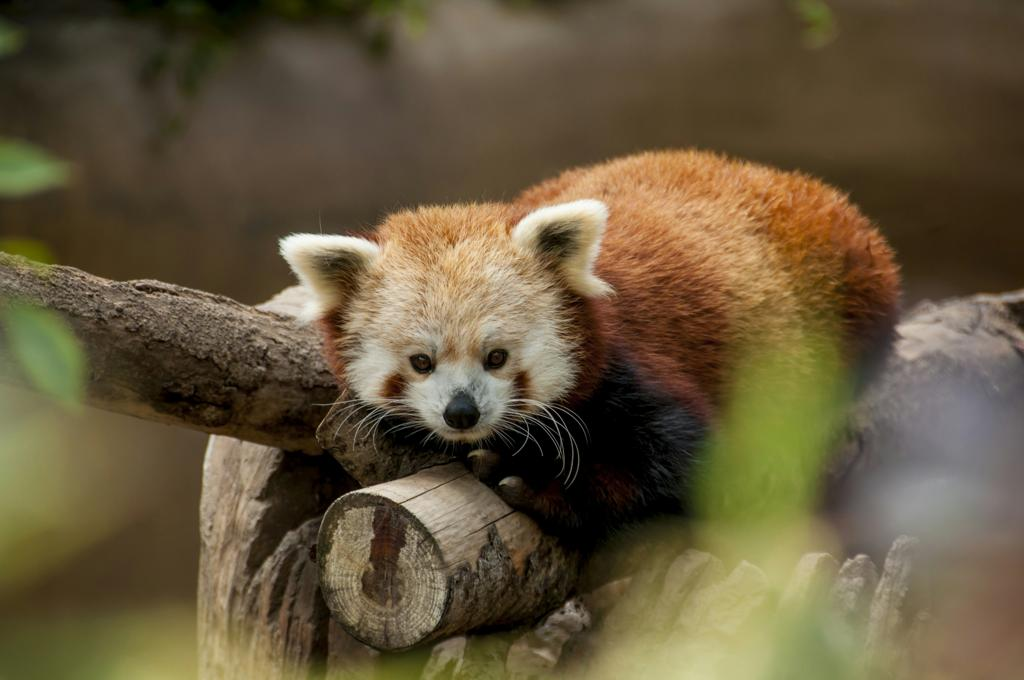

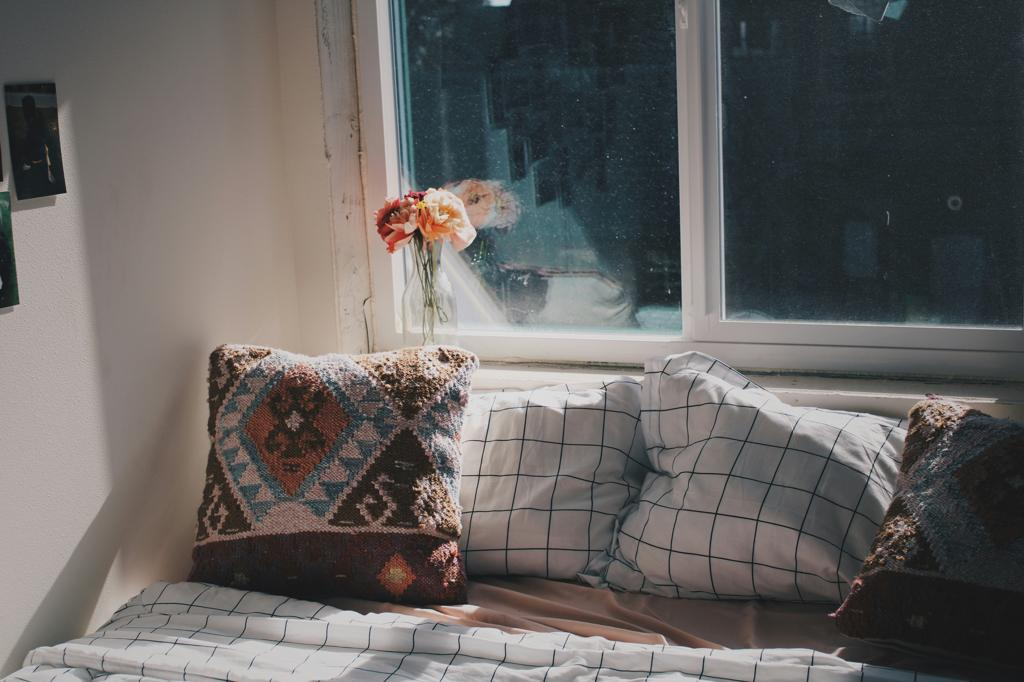

Place the red panda on the edge of the bed, curling up against the decorative pillows as it gazes out the window, soaking in the warm sunlight.
----------


100%|██████████| 49/49 [06:11<00:00,  7.59s/it]


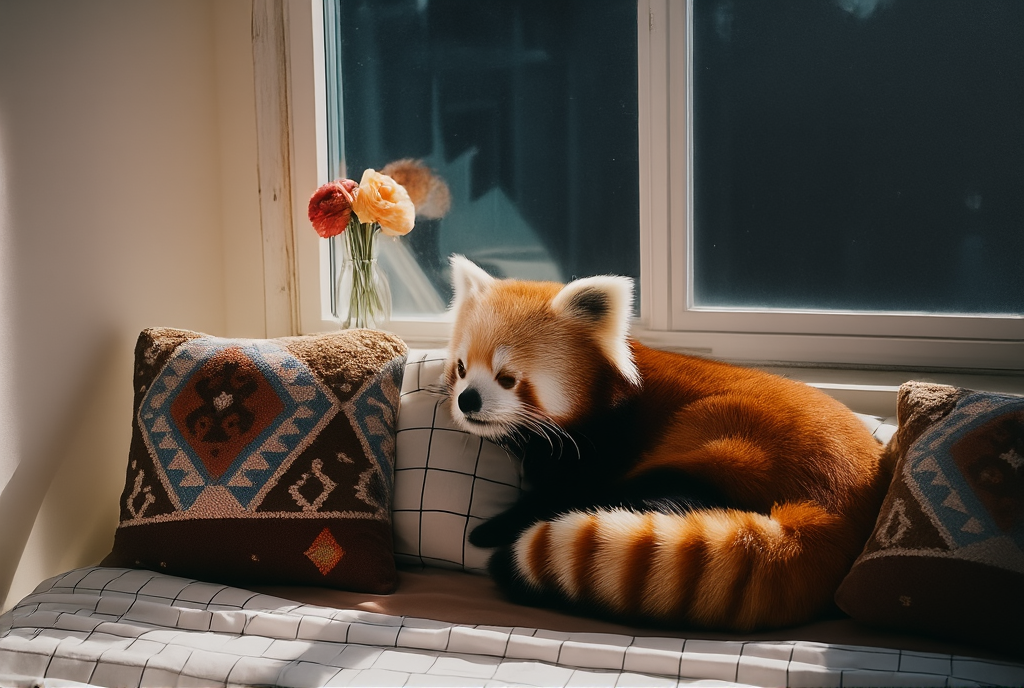

In [ ]:
# TODO: add multiple images in the list below
image = [Image.open('test_images/panda.jpg'),Image.open('test_images/bed.jpg')]
prompt = 'Place the red panda on the edge of the bed, curling up against the decorative pillows as it gazes out the window, soaking in the warm sunlight.'

display(image[0])
display(image[1])
print(prompt)
print('-'*10)
output_dict = inferencer(image=image, text=prompt, **inference_hyper)
display(output_dict['image'])